Prepare the repo & install Qpytorch+

In [ ]:
# !pip install ninja
# !pip install qtorch-plus

# CIFAR10 Low Precision Training Example in Posit P(8,2) format 
In this notebook, we present a quick example of how to simulate training a deep neural network in low precision with the Posit Extension in  QPyTorch.

In [1]:
# import useful modules
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD
# from qtorch_plus.quant import Quantizer, quantizer
# from qtorch_plus.optim import OptimLP
# from qtorch_plus import FloatingPoint, Posit
from tqdm.notebook import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt

We first load the data. In this example, we will experiment with CIFAR10.

In [2]:
# loading data
ds = torchvision.datasets.CIFAR10
path = os.path.join("./data", "CIFAR10")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_set = ds(path, train=True, download=True, transform=transform_train)
test_set = ds(path, train=False, download=True, transform=transform_test)
loaders = {
        'train': torch.utils.data.DataLoader(
            train_set,
            batch_size=128,
            shuffle=True,
            num_workers=8,
            pin_memory=True
        ),
        'test': torch.utils.data.DataLoader(
            test_set,
            batch_size=128,
            num_workers=8,
            pin_memory=True
        )
}

Files already downloaded and verified
Files already downloaded and verified


We then define the quantization setting we are going to use. In particular, here we follow the setting reported in the paper "Training Deep Neural Networks with 8-bit Floating Point Numbers", where the authors propose to use specialized 8-bit and 16-bit floating point format.

In [3]:
# # define two floating point formats
# bit_8  = Posit(nsize=8,  es=2)
# bit_10 = Posit(nsize=10, es=2)
# bit_12 = Posit(nsize=12, es=2)
# bit_14 = Posit(nsize=14, es=2)
# bit_16 = Posit(nsize=16, es=2)
# IEEE_Half = FloatingPoint(exp=5, man=10)
# bfloat16  = FloatingPoint(exp=8, man=7 )
# # Not supported formats
# # # bit_20 = Posit(nsize=20, es=2)
# # # bit_24 = Posit(nsize=24, es=2)
# # # bit_28 = Posit(nsize=28, es=2)
# # # bit_32 = Posit(nsize=32, es=2)

# # define quantization functions
# weight_quant = quantizer(forward_number=bit_14,
#                         forward_rounding="nearest")
# grad_quant = quantizer(forward_number=bit_14,
#                         forward_rounding="nearest")
# momentum_quant = quantizer(forward_number=bit_14,
#                         forward_rounding="stochastic")
# acc_quant = quantizer(forward_number=bit_14,
#                         forward_rounding="stochastic")

# # define a lambda function so that the Quantizer module can be duplicated easily
# act_error_quant = lambda : Quantizer(forward_number=bit_14, backward_number=bit_14,
#                         forward_rounding="nearest", backward_rounding="nearest")


torch.manual_seed(0)
np.random.seed(0)

Next, we define a low-precision ResNet. In the definition, we recursively insert quantization module after every convolution layer. Note that the quantization of weight, gradient, momentum, and gradient accumulator are not handled here.

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride
        # self.quant = quant()

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        # out = self.quant(out)
        out = self.conv1(out)
        # out = self.quant(out)

        out = self.bn2(out)
        out = self.relu(out)
        # out = self.quant(out)
        out = self.conv2(out)
        # out = self.quant(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out
    
class PreResNet(nn.Module):

    def __init__(self, num_classes=10, depth=20):

        super(PreResNet, self).__init__()
        assert (depth - 2) % 6 == 0, 'depth should be 6n+2'
        n = (depth - 2) // 6

        block = BasicBlock

        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.bn = nn.BatchNorm2d(64 * block.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)
        # self.quant = quant()
        # IBM_half = FloatingPoint(exp=6, man=9)
        # self.quant_half = Quantizer(IBM_half, IBM_half, "nearest", "nearest")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # x = self.quant_half(x)
        x = self.conv1(x)
        # x = self.quant(x)

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.bn(x)
        x = self.relu(x)
        # x = self.quant(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = self.quant_half(x)

        return x

In [4]:
# model = PreResNet(act_error_quant)
model = PreResNet()

In [5]:
device = 'cuda' # change device to 'cpu' if you want to run this example on cpu
model = model.to(device=device)

We now use the low-precision optimizer wrapper to help define the quantization of weight, gradient, momentum, and gradient accumulator.

In [6]:
optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
# optimizer = OptimLP(optimizer,
#                     weight_quant=weight_quant,
#                     grad_quant=grad_quant,
#                     momentum_quant=momentum_quant,
#                     acc_quant=acc_quant,
#                     grad_scaling=1/1000 # do gradient scaling
# )

We can reuse common training scripts without any extra codes to handle quantization.

In [7]:
def run_epoch(loader, model, criterion, optimizer=None, phase="train"):
    assert phase in ["train", "eval"], "invalid running phase"
    loss_sum = 0.0
    correct = 0.0

    if phase=="train": model.train()
    elif phase=="eval": model.eval()

    ttl = 0
    with torch.autograd.set_grad_enabled(phase=="train"):
        for i, (input, target) in tqdm(enumerate(loader), total=len(loader)):
            input = input.to(device=device)
            target = target.to(device=device)
            output = model(input)
            loss = criterion(output, target)
            loss_sum += loss.cpu().item() * input.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            ttl += input.size()[0]

            if phase=="train":
                # loss = loss * 1000 # do gradient scaling
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    correct = correct.cpu().item()
    return {
        'loss': loss_sum / float(ttl),
        'accuracy': correct / float(ttl) * 100.0,
    }

Begin the training process just as usual. Enjoy!

In [8]:
# history = {}
train_hist = []
test_hist = []

In [9]:
EPOCHS=100
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_res = run_epoch(loaders['train'], model, F.cross_entropy,
                                optimizer=optimizer, phase="train")
    train_hist += [train_res]
    print(train_res)
    test_res = run_epoch(loaders['test'], model, F.cross_entropy,
                                optimizer=optimizer, phase="eval")
    test_hist += [test_res]
    print(test_res)

Epoch 1/100


100%|██████████| 391/391 [00:11<00:00, 33.72it/s]

{'loss': 1.625574479446411, 'accuracy': 38.388}



100%|██████████| 79/79 [00:00<00:00, 94.26it/s] 

{'loss': 1.5144751218795776, 'accuracy': 46.46}
Epoch 2/100



100%|██████████| 391/391 [00:11<00:00, 33.79it/s]

{'loss': 1.1512176176643372, 'accuracy': 58.111999999999995}



100%|██████████| 79/79 [00:00<00:00, 92.01it/s] 

{'loss': 1.2266409551620483, 'accuracy': 56.779999999999994}
Epoch 3/100



100%|██████████| 391/391 [00:11<00:00, 33.83it/s]

{'loss': 0.9557962851142884, 'accuracy': 65.678}



100%|██████████| 79/79 [00:00<00:00, 95.85it/s] 

{'loss': 1.0830601506233215, 'accuracy': 61.7}
Epoch 4/100



100%|██████████| 391/391 [00:11<00:00, 33.44it/s]

{'loss': 0.8196717658805848, 'accuracy': 71.152}



100%|██████████| 79/79 [00:00<00:00, 93.70it/s] 

{'loss': 1.0084036096572877, 'accuracy': 66.39}
Epoch 5/100



100%|██████████| 391/391 [00:11<00:00, 32.61it/s]

{'loss': 0.7294434660720825, 'accuracy': 74.648}



100%|██████████| 79/79 [00:00<00:00, 86.00it/s]

{'loss': 0.8821717509269714, 'accuracy': 71.00999999999999}
Epoch 6/100



100%|██████████| 391/391 [00:12<00:00, 32.10it/s]

{'loss': 0.6629874605941772, 'accuracy': 76.99000000000001}



100%|██████████| 79/79 [00:00<00:00, 87.99it/s] 

{'loss': 0.8793933035850525, 'accuracy': 71.88}
Epoch 7/100



100%|██████████| 391/391 [00:12<00:00, 30.77it/s]

{'loss': 0.6213292938613891, 'accuracy': 78.616}



100%|██████████| 79/79 [00:00<00:00, 86.34it/s]

{'loss': 0.8937820639610291, 'accuracy': 70.96000000000001}
Epoch 8/100



100%|██████████| 391/391 [00:12<00:00, 30.61it/s]

{'loss': 0.5846299231338501, 'accuracy': 79.85799999999999}



100%|██████████| 79/79 [00:00<00:00, 85.61it/s]

{'loss': 0.6146675889015197, 'accuracy': 79.4}
Epoch 9/100



100%|██████████| 391/391 [00:12<00:00, 30.74it/s]

{'loss': 0.5664876664924622, 'accuracy': 80.592}



100%|██████████| 79/79 [00:00<00:00, 84.42it/s] 

{'loss': 0.6896979318618774, 'accuracy': 77.45}
Epoch 10/100



100%|██████████| 391/391 [00:12<00:00, 30.45it/s]

{'loss': 0.5404976709365845, 'accuracy': 81.504}



100%|██████████| 79/79 [00:00<00:00, 85.58it/s]

{'loss': 0.693002471446991, 'accuracy': 76.75}
Epoch 11/100



100%|██████████| 391/391 [00:12<00:00, 30.80it/s]

{'loss': 0.5222092705535889, 'accuracy': 82.13000000000001}



100%|██████████| 79/79 [00:00<00:00, 84.07it/s]

{'loss': 0.6681184819221496, 'accuracy': 76.67}
Epoch 12/100



100%|██████████| 391/391 [00:12<00:00, 30.49it/s]

{'loss': 0.5112865567588806, 'accuracy': 82.556}



100%|██████████| 79/79 [00:00<00:00, 80.02it/s]

{'loss': 0.6252630041122437, 'accuracy': 78.85}
Epoch 13/100



100%|██████████| 391/391 [00:12<00:00, 30.76it/s]

{'loss': 0.4971350238895416, 'accuracy': 82.87}



100%|██████████| 79/79 [00:00<00:00, 95.26it/s] 

{'loss': 0.7164005813598633, 'accuracy': 76.14}
Epoch 14/100



100%|██████████| 391/391 [00:12<00:00, 32.21it/s]

{'loss': 0.4864516795253754, 'accuracy': 83.206}



100%|██████████| 79/79 [00:00<00:00, 96.07it/s] 

{'loss': 0.5981417360305786, 'accuracy': 79.74}
Epoch 15/100



100%|██████████| 391/391 [00:11<00:00, 32.61it/s]

{'loss': 0.474302197265625, 'accuracy': 83.69}



100%|██████████| 79/79 [00:00<00:00, 95.20it/s] 

{'loss': 0.5808214054107667, 'accuracy': 80.56}
Epoch 16/100



100%|██████████| 391/391 [00:12<00:00, 32.20it/s]

{'loss': 0.4618099147796631, 'accuracy': 84.124}



100%|██████████| 79/79 [00:00<00:00, 93.43it/s] 

{'loss': 0.5762607214927673, 'accuracy': 80.64}
Epoch 17/100



100%|██████████| 391/391 [00:12<00:00, 32.55it/s]

{'loss': 0.46311907395362856, 'accuracy': 84.032}



100%|██████████| 79/79 [00:00<00:00, 94.92it/s] 

{'loss': 0.6896970679283142, 'accuracy': 77.91}
Epoch 18/100



100%|██████████| 391/391 [00:12<00:00, 32.20it/s]

{'loss': 0.4535446789932251, 'accuracy': 84.396}



100%|██████████| 79/79 [00:00<00:00, 88.38it/s] 

{'loss': 0.6697665160655976, 'accuracy': 78.73}
Epoch 19/100



100%|██████████| 391/391 [00:12<00:00, 32.20it/s]

{'loss': 0.4473234027290344, 'accuracy': 84.694}



100%|██████████| 79/79 [00:00<00:00, 92.27it/s] 

{'loss': 0.6472042491912842, 'accuracy': 79.11}
Epoch 20/100



100%|██████████| 391/391 [00:12<00:00, 32.44it/s]

{'loss': 0.4392038113307953, 'accuracy': 84.816}



100%|██████████| 79/79 [00:00<00:00, 89.52it/s] 

{'loss': 0.5591972323894501, 'accuracy': 81.04}
Epoch 21/100



100%|██████████| 391/391 [00:12<00:00, 31.81it/s]

{'loss': 0.4342734261417389, 'accuracy': 85.294}



100%|██████████| 79/79 [00:00<00:00, 91.14it/s] 

{'loss': 0.5098194981098175, 'accuracy': 83.12}
Epoch 22/100



100%|██████████| 391/391 [00:12<00:00, 32.08it/s]

{'loss': 0.4272539657592773, 'accuracy': 85.306}



100%|██████████| 79/79 [00:00<00:00, 93.69it/s] 

{'loss': 0.5989650384902954, 'accuracy': 79.57}
Epoch 23/100



100%|██████████| 391/391 [00:12<00:00, 32.55it/s]

{'loss': 0.4268760438156128, 'accuracy': 85.28}



100%|██████████| 79/79 [00:00<00:00, 94.19it/s] 

{'loss': 0.6657842805862427, 'accuracy': 78.92}
Epoch 24/100



100%|██████████| 391/391 [00:12<00:00, 32.28it/s]

{'loss': 0.41854129633903503, 'accuracy': 85.68599999999999}



100%|██████████| 79/79 [00:00<00:00, 91.87it/s] 

{'loss': 0.6091838111877441, 'accuracy': 80.42}
Epoch 25/100



100%|██████████| 391/391 [00:12<00:00, 32.06it/s]

{'loss': 0.41398466446876525, 'accuracy': 85.89}



100%|██████████| 79/79 [00:00<00:00, 90.54it/s] 

{'loss': 0.6263627688884735, 'accuracy': 79.88}
Epoch 26/100



100%|██████████| 391/391 [00:12<00:00, 32.16it/s]

{'loss': 0.4108688829708099, 'accuracy': 85.81400000000001}



100%|██████████| 79/79 [00:00<00:00, 88.83it/s] 

{'loss': 0.618359699344635, 'accuracy': 79.79}
Epoch 27/100



100%|██████████| 391/391 [00:12<00:00, 32.25it/s]

{'loss': 0.40914697093963626, 'accuracy': 85.924}



100%|██████████| 79/79 [00:00<00:00, 91.49it/s] 

{'loss': 0.5914669493675232, 'accuracy': 80.51}
Epoch 28/100



100%|██████████| 391/391 [00:12<00:00, 32.06it/s]

{'loss': 0.3994539458274841, 'accuracy': 86.182}



100%|██████████| 79/79 [00:00<00:00, 93.70it/s] 

{'loss': 0.5292761014938354, 'accuracy': 82.39999999999999}
Epoch 29/100



100%|██████████| 391/391 [00:12<00:00, 32.09it/s]

{'loss': 0.40676726816177367, 'accuracy': 86.0}



100%|██████████| 79/79 [00:00<00:00, 93.93it/s] 

{'loss': 0.6519664402008056, 'accuracy': 78.11}
Epoch 30/100



100%|██████████| 391/391 [00:12<00:00, 31.74it/s]

{'loss': 0.4011272583389282, 'accuracy': 86.102}



100%|██████████| 79/79 [00:00<00:00, 95.47it/s] 

{'loss': 0.5380424755096436, 'accuracy': 82.28}
Epoch 31/100



100%|██████████| 391/391 [00:12<00:00, 32.21it/s]

{'loss': 0.3900735901546478, 'accuracy': 86.458}



100%|██████████| 79/79 [00:00<00:00, 91.68it/s] 

{'loss': 0.5007230050086975, 'accuracy': 82.88}
Epoch 32/100



100%|██████████| 391/391 [00:12<00:00, 32.32it/s]

{'loss': 0.3987997802734375, 'accuracy': 86.298}



100%|██████████| 79/79 [00:00<00:00, 93.80it/s] 

{'loss': 0.7715281396865845, 'accuracy': 76.1}
Epoch 33/100



100%|██████████| 391/391 [00:12<00:00, 32.53it/s]

{'loss': 0.38808407816886903, 'accuracy': 86.494}



100%|██████████| 79/79 [00:00<00:00, 91.80it/s] 

{'loss': 0.4871068077087402, 'accuracy': 83.45}
Epoch 34/100



100%|██████████| 391/391 [00:12<00:00, 32.51it/s]

{'loss': 0.3865021412229538, 'accuracy': 86.632}



100%|██████████| 79/79 [00:00<00:00, 88.16it/s]

{'loss': 0.565680668592453, 'accuracy': 81.11}
Epoch 35/100



100%|██████████| 391/391 [00:11<00:00, 32.64it/s]

{'loss': 0.38731777678489687, 'accuracy': 86.61999999999999}



100%|██████████| 79/79 [00:00<00:00, 88.80it/s] 

{'loss': 0.49692362360954284, 'accuracy': 83.89}
Epoch 36/100



100%|██████████| 391/391 [00:11<00:00, 33.06it/s]

{'loss': 0.3835843559265137, 'accuracy': 86.758}



100%|██████████| 79/79 [00:00<00:00, 91.74it/s] 

{'loss': 0.5046737089633941, 'accuracy': 83.15}
Epoch 37/100



100%|██████████| 391/391 [00:11<00:00, 33.17it/s]

{'loss': 0.3818737239074707, 'accuracy': 86.904}



100%|██████████| 79/79 [00:00<00:00, 95.60it/s] 

{'loss': 0.5299521025180817, 'accuracy': 82.80999999999999}
Epoch 38/100



100%|██████████| 391/391 [00:11<00:00, 33.12it/s]

{'loss': 0.38548628425598147, 'accuracy': 86.77}



100%|██████████| 79/79 [00:00<00:00, 93.24it/s] 

{'loss': 0.6119793835639954, 'accuracy': 80.22}
Epoch 39/100



100%|██████████| 391/391 [00:11<00:00, 33.21it/s]

{'loss': 0.37582629073143003, 'accuracy': 87.004}



100%|██████████| 79/79 [00:00<00:00, 90.86it/s] 

{'loss': 0.6013774846553802, 'accuracy': 79.95}
Epoch 40/100



100%|██████████| 391/391 [00:12<00:00, 32.12it/s]

{'loss': 0.37154115827560424, 'accuracy': 87.22}



100%|██████████| 79/79 [00:00<00:00, 93.20it/s] 

{'loss': 0.6178055745124816, 'accuracy': 80.77}
Epoch 41/100



100%|██████████| 391/391 [00:11<00:00, 32.81it/s]

{'loss': 0.3769939646053314, 'accuracy': 87.078}



100%|██████████| 79/79 [00:00<00:00, 90.53it/s] 

{'loss': 0.5695531393289566, 'accuracy': 81.10000000000001}
Epoch 42/100



100%|██████████| 391/391 [00:11<00:00, 32.99it/s]

{'loss': 0.3707276937675476, 'accuracy': 87.22800000000001}



100%|██████████| 79/79 [00:00<00:00, 92.30it/s] 

{'loss': 0.48217527341842653, 'accuracy': 83.39999999999999}
Epoch 43/100



100%|██████████| 391/391 [00:11<00:00, 33.15it/s]

{'loss': 0.37283818194389345, 'accuracy': 87.002}



100%|██████████| 79/79 [00:00<00:00, 93.28it/s] 

{'loss': 0.4817823831558228, 'accuracy': 84.14}
Epoch 44/100



100%|██████████| 391/391 [00:11<00:00, 33.18it/s]

{'loss': 0.37154234754562376, 'accuracy': 87.176}



100%|██████████| 79/79 [00:00<00:00, 94.48it/s] 

{'loss': 0.5021052166938782, 'accuracy': 83.46000000000001}
Epoch 45/100



100%|██████████| 391/391 [00:11<00:00, 33.10it/s]

{'loss': 0.3706975533390045, 'accuracy': 87.48}



100%|██████████| 79/79 [00:00<00:00, 95.71it/s] 

{'loss': 0.5193714010238647, 'accuracy': 82.67999999999999}
Epoch 46/100



100%|██████████| 391/391 [00:11<00:00, 33.10it/s]

{'loss': 0.3660597692298889, 'accuracy': 87.364}



100%|██████████| 79/79 [00:00<00:00, 92.71it/s] 

{'loss': 0.6707366035461426, 'accuracy': 78.7}
Epoch 47/100



100%|██████████| 391/391 [00:11<00:00, 32.99it/s]

{'loss': 0.3731452625656128, 'accuracy': 87.08}



100%|██████████| 79/79 [00:00<00:00, 92.71it/s] 

{'loss': 0.46257386646270754, 'accuracy': 84.66}
Epoch 48/100



100%|██████████| 391/391 [00:11<00:00, 32.62it/s]

{'loss': 0.3639176380443573, 'accuracy': 87.466}



100%|██████████| 79/79 [00:00<00:00, 92.25it/s] 

{'loss': 0.5467954849243164, 'accuracy': 81.84}
Epoch 49/100



100%|██████████| 391/391 [00:12<00:00, 32.27it/s]

{'loss': 0.35795527026176455, 'accuracy': 87.696}



100%|██████████| 79/79 [00:00<00:00, 87.42it/s]

{'loss': 0.46976931848526, 'accuracy': 84.82}
Epoch 50/100



100%|██████████| 391/391 [00:12<00:00, 32.51it/s]

{'loss': 0.3624265990066528, 'accuracy': 87.51}



100%|██████████| 79/79 [00:00<00:00, 91.19it/s] 

{'loss': 0.5850056086540222, 'accuracy': 80.25}
Epoch 51/100



100%|██████████| 391/391 [00:11<00:00, 32.94it/s]

{'loss': 0.3634246531391144, 'accuracy': 87.496}



100%|██████████| 79/79 [00:00<00:00, 90.75it/s] 

{'loss': 0.5159612222671509, 'accuracy': 83.03}
Epoch 52/100



100%|██████████| 391/391 [00:12<00:00, 32.49it/s]

{'loss': 0.35703955478668215, 'accuracy': 87.874}



100%|██████████| 79/79 [00:00<00:00, 92.08it/s] 

{'loss': 0.45349973843097685, 'accuracy': 85.17}
Epoch 53/100



100%|██████████| 391/391 [00:12<00:00, 32.54it/s]

{'loss': 0.3593664178657532, 'accuracy': 87.576}



100%|██████████| 79/79 [00:00<00:00, 92.07it/s] 

{'loss': 0.5723652905941009, 'accuracy': 81.32000000000001}
Epoch 54/100



100%|██████████| 391/391 [00:11<00:00, 32.97it/s]

{'loss': 0.35220127660751344, 'accuracy': 87.968}



100%|██████████| 79/79 [00:00<00:00, 91.86it/s] 

{'loss': 0.5046110521316528, 'accuracy': 83.58}
Epoch 55/100



100%|██████████| 391/391 [00:11<00:00, 32.96it/s]

{'loss': 0.3641568091773987, 'accuracy': 87.402}



100%|██████████| 79/79 [00:00<00:00, 97.30it/s] 

{'loss': 0.41998296570777893, 'accuracy': 85.61}
Epoch 56/100



100%|██████████| 391/391 [00:11<00:00, 32.97it/s]

{'loss': 0.3588871139240265, 'accuracy': 87.724}



100%|██████████| 79/79 [00:00<00:00, 97.99it/s] 

{'loss': 0.5161621633052826, 'accuracy': 83.16}
Epoch 57/100



100%|██████████| 391/391 [00:11<00:00, 32.73it/s]

{'loss': 0.35605809920310977, 'accuracy': 87.878}



100%|██████████| 79/79 [00:00<00:00, 91.91it/s] 

{'loss': 0.4445908190727234, 'accuracy': 85.05}
Epoch 58/100



100%|██████████| 391/391 [00:11<00:00, 32.74it/s]

{'loss': 0.354908247833252, 'accuracy': 87.836}



100%|██████████| 79/79 [00:00<00:00, 94.89it/s] 

{'loss': 0.4291636820793152, 'accuracy': 85.68}
Epoch 59/100



100%|██████████| 391/391 [00:11<00:00, 32.91it/s]


{'loss': 0.34818731065750125, 'accuracy': 88.046}


100%|██████████| 79/79 [00:00<00:00, 93.14it/s] 

{'loss': 0.6075594363927841, 'accuracy': 79.89}
Epoch 60/100



100%|██████████| 391/391 [00:11<00:00, 32.73it/s]

{'loss': 0.3521933321094513, 'accuracy': 87.874}



100%|██████████| 79/79 [00:00<00:00, 92.59it/s] 

{'loss': 0.7592135966777801, 'accuracy': 76.59}
Epoch 61/100



100%|██████████| 391/391 [00:11<00:00, 32.65it/s]

{'loss': 0.3577152555465698, 'accuracy': 87.668}



100%|██████████| 79/79 [00:00<00:00, 95.36it/s] 

{'loss': 0.6447589618682862, 'accuracy': 80.49}
Epoch 62/100



100%|██████████| 391/391 [00:11<00:00, 32.63it/s]

{'loss': 0.34857464428901674, 'accuracy': 88.066}



100%|██████████| 79/79 [00:00<00:00, 94.39it/s] 

{'loss': 0.6824166407108306, 'accuracy': 79.02}
Epoch 63/100



100%|██████████| 391/391 [00:11<00:00, 32.63it/s]

{'loss': 0.3526284453868866, 'accuracy': 87.972}



100%|██████████| 79/79 [00:00<00:00, 95.05it/s] 

{'loss': 0.5228523008823395, 'accuracy': 83.12}
Epoch 64/100



100%|██████████| 391/391 [00:11<00:00, 32.69it/s]

{'loss': 0.34927956768989565, 'accuracy': 87.91}



100%|██████████| 79/79 [00:00<00:00, 93.98it/s] 

{'loss': 0.48593971242904666, 'accuracy': 84.32}
Epoch 65/100



100%|██████████| 391/391 [00:11<00:00, 32.76it/s]

{'loss': 0.3448778262710571, 'accuracy': 88.096}



100%|██████████| 79/79 [00:00<00:00, 94.12it/s] 

{'loss': 0.5699059769153595, 'accuracy': 81.62}
Epoch 66/100



100%|██████████| 391/391 [00:11<00:00, 32.62it/s]

{'loss': 0.35224633984565734, 'accuracy': 87.852}



100%|██████████| 79/79 [00:00<00:00, 91.87it/s] 

{'loss': 0.5217446995973587, 'accuracy': 82.56}
Epoch 67/100



100%|██████████| 391/391 [00:12<00:00, 32.53it/s]

{'loss': 0.34895044832229616, 'accuracy': 88.048}



100%|██████████| 79/79 [00:00<00:00, 96.00it/s] 

{'loss': 0.5773730772972107, 'accuracy': 81.52000000000001}
Epoch 68/100



100%|██████████| 391/391 [00:12<00:00, 32.46it/s]

{'loss': 0.35167739459991454, 'accuracy': 87.912}



100%|██████████| 79/79 [00:00<00:00, 96.32it/s] 

{'loss': 0.6961006798744201, 'accuracy': 79.66}
Epoch 69/100



100%|██████████| 391/391 [00:11<00:00, 32.59it/s]

{'loss': 0.34663520730018615, 'accuracy': 87.992}



100%|██████████| 79/79 [00:00<00:00, 96.54it/s] 


{'loss': 0.5414217625141143, 'accuracy': 82.39}
Epoch 70/100


100%|██████████| 391/391 [00:12<00:00, 32.53it/s]

{'loss': 0.34689706243515017, 'accuracy': 88.14800000000001}



100%|██████████| 79/79 [00:00<00:00, 91.32it/s] 

{'loss': 0.5254563508033753, 'accuracy': 82.99}
Epoch 71/100



100%|██████████| 391/391 [00:12<00:00, 32.54it/s]

{'loss': 0.35199607791900633, 'accuracy': 87.81400000000001}



100%|██████████| 79/79 [00:00<00:00, 94.49it/s] 

{'loss': 0.5097800261974335, 'accuracy': 83.69}
Epoch 72/100



100%|██████████| 391/391 [00:12<00:00, 32.55it/s]

{'loss': 0.3429460664653778, 'accuracy': 88.152}



100%|██████████| 79/79 [00:00<00:00, 91.10it/s] 

{'loss': 0.5263864826202392, 'accuracy': 82.49}
Epoch 73/100



100%|██████████| 391/391 [00:11<00:00, 32.63it/s]

{'loss': 0.3446808115673065, 'accuracy': 88.09}



100%|██████████| 79/79 [00:00<00:00, 92.19it/s] 

{'loss': 0.4939646978378296, 'accuracy': 82.98}
Epoch 74/100



100%|██████████| 391/391 [00:12<00:00, 32.48it/s]

{'loss': 0.3478840254020691, 'accuracy': 88.22}



100%|██████████| 79/79 [00:00<00:00, 90.94it/s] 

{'loss': 0.46017862691879274, 'accuracy': 84.7}
Epoch 75/100



100%|██████████| 391/391 [00:11<00:00, 32.76it/s]

{'loss': 0.3405273412132263, 'accuracy': 88.128}



100%|██████████| 79/79 [00:00<00:00, 92.88it/s] 

{'loss': 0.47221935911178586, 'accuracy': 84.1}
Epoch 76/100



100%|██████████| 391/391 [00:11<00:00, 32.59it/s]

{'loss': 0.3449485430717468, 'accuracy': 88.236}



100%|██████████| 79/79 [00:00<00:00, 93.47it/s] 

{'loss': 0.5304206355571747, 'accuracy': 82.6}
Epoch 77/100



100%|██████████| 391/391 [00:11<00:00, 32.72it/s]

{'loss': 0.3421324343967438, 'accuracy': 88.22}



100%|██████████| 79/79 [00:00<00:00, 92.43it/s] 

{'loss': 0.42010509910583493, 'accuracy': 86.1}
Epoch 78/100



100%|██████████| 391/391 [00:12<00:00, 32.58it/s]

{'loss': 0.34235182423591615, 'accuracy': 88.202}



100%|██████████| 79/79 [00:00<00:00, 93.88it/s] 

{'loss': 0.4518409058570862, 'accuracy': 85.26}
Epoch 79/100



100%|██████████| 391/391 [00:11<00:00, 32.66it/s]

{'loss': 0.3401436476802826, 'accuracy': 88.166}



100%|██████████| 79/79 [00:00<00:00, 92.64it/s] 

{'loss': 0.5024321081161499, 'accuracy': 82.97}
Epoch 80/100



100%|██████████| 391/391 [00:12<00:00, 32.58it/s]

{'loss': 0.3385085807991028, 'accuracy': 88.39200000000001}



100%|██████████| 79/79 [00:00<00:00, 94.15it/s] 

{'loss': 0.4864227265357971, 'accuracy': 83.95}
Epoch 81/100



100%|██████████| 391/391 [00:11<00:00, 32.74it/s]

{'loss': 0.3428511461353302, 'accuracy': 88.198}



100%|██████████| 79/79 [00:00<00:00, 88.69it/s] 

{'loss': 0.4963430435180664, 'accuracy': 83.95}
Epoch 82/100



100%|██████████| 391/391 [00:11<00:00, 32.74it/s]

{'loss': 0.34239757657051084, 'accuracy': 88.238}



100%|██████████| 79/79 [00:00<00:00, 92.63it/s] 

{'loss': 0.4732893741607666, 'accuracy': 84.46000000000001}
Epoch 83/100



100%|██████████| 391/391 [00:11<00:00, 32.85it/s]

{'loss': 0.3376333825302124, 'accuracy': 88.42999999999999}



100%|██████████| 79/79 [00:00<00:00, 93.04it/s] 

{'loss': 0.4601151685237885, 'accuracy': 85.03}
Epoch 84/100



100%|██████████| 391/391 [00:11<00:00, 32.81it/s]

{'loss': 0.33681328828811646, 'accuracy': 88.36}



100%|██████████| 79/79 [00:00<00:00, 94.83it/s] 

{'loss': 0.5364951926231384, 'accuracy': 81.88}
Epoch 85/100



100%|██████████| 391/391 [00:11<00:00, 32.89it/s]

{'loss': 0.336830431432724, 'accuracy': 88.476}



100%|██████████| 79/79 [00:00<00:00, 91.28it/s] 

{'loss': 0.55506374168396, 'accuracy': 82.36}
Epoch 86/100



100%|██████████| 391/391 [00:11<00:00, 32.97it/s]

{'loss': 0.3385541616249084, 'accuracy': 88.276}



100%|██████████| 79/79 [00:00<00:00, 96.26it/s] 

{'loss': 0.5910717092990875, 'accuracy': 81.6}
Epoch 87/100



100%|██████████| 391/391 [00:11<00:00, 32.97it/s]

{'loss': 0.3340821620750427, 'accuracy': 88.616}



100%|██████████| 79/79 [00:00<00:00, 92.45it/s] 

{'loss': 0.7141466371536255, 'accuracy': 77.81}
Epoch 88/100



100%|██████████| 391/391 [00:11<00:00, 32.93it/s]

{'loss': 0.33937184517860414, 'accuracy': 88.304}



100%|██████████| 79/79 [00:00<00:00, 95.47it/s] 

{'loss': 0.45171463890075686, 'accuracy': 84.99}
Epoch 89/100



100%|██████████| 391/391 [00:11<00:00, 32.79it/s]

{'loss': 0.3378347432041168, 'accuracy': 88.364}



100%|██████████| 79/79 [00:00<00:00, 92.94it/s] 

{'loss': 0.504518055152893, 'accuracy': 83.46000000000001}
Epoch 90/100



100%|██████████| 391/391 [00:11<00:00, 32.80it/s]

{'loss': 0.3424513956737518, 'accuracy': 88.092}



100%|██████████| 79/79 [00:00<00:00, 95.11it/s] 

{'loss': 0.4179130614757538, 'accuracy': 86.5}
Epoch 91/100



100%|██████████| 391/391 [00:11<00:00, 32.63it/s]

{'loss': 0.3324704769039154, 'accuracy': 88.682}



100%|██████████| 79/79 [00:00<00:00, 90.95it/s] 

{'loss': 0.5876509531021118, 'accuracy': 81.15}
Epoch 92/100



100%|██████████| 391/391 [00:11<00:00, 32.62it/s]

{'loss': 0.3371299276447296, 'accuracy': 88.352}



100%|██████████| 79/79 [00:00<00:00, 95.27it/s] 

{'loss': 0.4535553874015808, 'accuracy': 85.16}
Epoch 93/100



100%|██████████| 391/391 [00:11<00:00, 33.09it/s]

{'loss': 0.33271248126983644, 'accuracy': 88.56}



100%|██████████| 79/79 [00:00<00:00, 93.02it/s] 

{'loss': 0.4805655331134796, 'accuracy': 84.28}
Epoch 94/100



100%|██████████| 391/391 [00:11<00:00, 33.15it/s]

{'loss': 0.3374336473274231, 'accuracy': 88.354}



100%|██████████| 79/79 [00:00<00:00, 93.40it/s] 

{'loss': 0.47923843297958374, 'accuracy': 84.31}
Epoch 95/100



100%|██████████| 391/391 [00:11<00:00, 33.13it/s]

{'loss': 0.33193029163360593, 'accuracy': 88.628}



100%|██████████| 79/79 [00:00<00:00, 95.50it/s] 

{'loss': 0.5679459339141846, 'accuracy': 81.94}
Epoch 96/100



100%|██████████| 391/391 [00:11<00:00, 33.00it/s]

{'loss': 0.33551287680625913, 'accuracy': 88.298}



100%|██████████| 79/79 [00:00<00:00, 95.94it/s] 

{'loss': 0.5763077203750611, 'accuracy': 81.51}
Epoch 97/100



100%|██████████| 391/391 [00:11<00:00, 32.77it/s]

{'loss': 0.3331594461917877, 'accuracy': 88.642}



100%|██████████| 79/79 [00:00<00:00, 98.51it/s] 

{'loss': 0.47072659153938295, 'accuracy': 84.55}
Epoch 98/100



100%|██████████| 391/391 [00:11<00:00, 32.81it/s]

{'loss': 0.3276488986492157, 'accuracy': 88.728}



100%|██████████| 79/79 [00:00<00:00, 93.37it/s] 

{'loss': 0.532489137172699, 'accuracy': 82.89}
Epoch 99/100



100%|██████████| 391/391 [00:11<00:00, 32.66it/s]

{'loss': 0.33486017337799073, 'accuracy': 88.486}



100%|██████████| 79/79 [00:00<00:00, 92.78it/s] 

{'loss': 0.5123224522590637, 'accuracy': 82.91}
Epoch 100/100



100%|██████████| 391/391 [00:11<00:00, 32.61it/s]

{'loss': 0.33315454042434695, 'accuracy': 88.532}



100%|██████████| 79/79 [00:00<00:00, 92.74it/s] 

{'loss': 0.584546003484726, 'accuracy': 81.64}


In [10]:
train_res, test_res

({'loss': 0.33315454042434695, 'accuracy': 88.532},
 {'loss': 0.584546003484726, 'accuracy': 81.64})

In [11]:
# Plotted the accuracy Graph
def plot_accuracies(train, test=None):
    accuracies = [x['accuracy'] for x in train]
    plt.plot(accuracies, label='Train')
    if test is not None:
        accuracies_test = [x['accuracy'] for x in test]
        plt.plot(accuracies_test, label='Test')
        plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [12]:
# Plotted the accuracy Graph
def plot_losses(train, test=None):
    accuracies = [x['loss'] for x in train]
    plt.plot(accuracies, label='Train')
    if test is not None:
        accuracies_test = [x['loss'] for x in test]
        plt.plot(accuracies_test, label='Test')
        plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

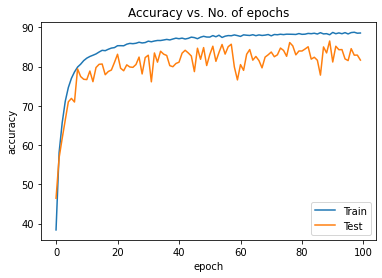

In [13]:
plot_accuracies(train_hist, test_hist)

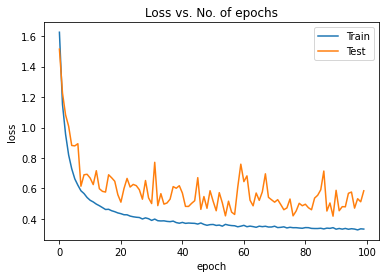

In [14]:
plot_losses(train_hist, test_hist)

In [15]:
import json

with open('train.hist', 'w') as fout:
    json.dump(train_hist, fout)

with open('test.hist', 'w') as fout:
    json.dump(test_hist, fout)


# with open('train.hist', 'r') as f_in:
#     train_hist = json.load(f_in)

# with open('test.hist', 'r') as fout:
#     test_hist = json.load(f_in)